In [1]:
import pandas as pd

# Data loading

In [2]:
df_emto = pd.read_json('./raw_data/emto.raw.json')
df_vasp = pd.read_json('./raw_data/vasp.raw.json')

# Data preprocessing

2 datasets, obtained using EMTO-CPA and PAW-SQS methods:

In [3]:
df_emto[['C_prime', 'c11', 'c12','c44', 'B', 'G', 'E']].describe().round().astype(int)

,C_prime,c11,c12,c44,B,G,E
count,1657,1657,1657,1657,1657,1657,1657
mean,32,167,104,69,125,48,126
std,24,59,18,12,29,17,45
min,-12,40,5,42,19,-8,-53
25%,11,121,95,62,106,35,93
50%,25,154,104,67,120,45,120
75%,47,202,112,75,141,57,151
max,112,373,199,124,234,110,286


In [4]:
df_vasp[['C_prime', 'c11', 'c12','c44', 'B', 'G', 'E']].describe().round().astype(int)

,C_prime,c11,c12,c44,B,G,E
count,62,62,62,62,62,62,62
mean,24,169,122,47,137,32,88
std,25,68,26,20,38,23,60
min,-12,83,90,17,88,-18,-58
25%,3,113,102,31,112,13,38
50%,20,156,116,42,125,28,79
75%,38,210,133,53,163,45,122
max,92,356,215,110,234,91,243


Add info about pure base lement (Ti) in ternaries dataset to add then all possible combinations of base elements and dopants with concentrations of 0.0

In [5]:
import numpy as np
from handlers import set_dopants_for_pure_elements

In [6]:
df_emto = set_dopants_for_pure_elements(df_emto, base='Ti')
df_emto = set_dopants_for_pure_elements(df_emto, base='Zr')

In [7]:
df_vasp = set_dopants_for_pure_elements(df_vasp, base='Ti')
df_vasp = set_dopants_for_pure_elements(df_vasp, base='Zr')

# Features engeneering

In [8]:
import warnings
warnings.filterwarnings("ignore") 

In [9]:
from handlers import mlb_feats_from_elemental_hull

Information about different forms of elements in the resulting investigated compositions were added from information on phase diagrams of pure elements from Materials Project data. 

The following concentration weighted properties have been used as a separate features: atomic number, electronegativity, row and group in a periodic table, atomic mass, atomic radius, molar volume, average ionic radius, maximal and minimal oxidation state. 

In addition to features that indirectly carry information about the properties and concentration of elements in each composition, we also use features that directly describe the concentrations of each of the 34 unique elements in each composition.

Finally, the last group of features was formed as a multi-label binarization of the space groups of elements in their stable crystalline forms, corresponding to each composition from Materials Project.

Elemental properties of the most stable form used for features in the concentration weighted form: calculated density, calculated relaxed volume per atom, calculated energy per atom, and total magnetization.

In [10]:
df_emto_feats = mlb_feats_from_elemental_hull(df_emto)

100%|██████████| 17/17 [00:12<00:00,  1.38it/s]


In [11]:
from handlers import convert_to_feats

In [12]:
df_emto_feats = convert_to_feats(df_emto_feats)

100%|██████████| 1729/1729 [00:00<00:00, 6032.04it/s]


# Models testing

The main concept of this work is creation of two models for each property trained in a specific way, in which the first one is trained on large datatset with less accurate calculations made using EMTO-CPA and the second is trained on the much smaller dataset from more accurate PAW-SQS calculations and prediction results from the first model.

In this work, a set of unique pipelines were found using an evolutionary algorithm, implemented in the “TPOT” python package. These pipelines were independently optimized to predict each considered elastic property. The raw data used as the input for the evolutionary algorithm were digitized datasets containing the extracted features. The evolutionary algorithm was set for 30 generations and a population size of 50 variants with a cross-validation of 100 folds for a model fitted with EMTO-CPA results, and to optimize the pipeline for predicting the PAW-SQS data, cross-validation was set for 30 folds. This repository ("ml_modelsЭ directory) contains all the pipelines obtained by the described method. 

**To explore different models following code should be changed:**

*All available properties to predict:*
- 'C_prime', 'B', 'E', 'G', 'c11', 'c12', 'c44'

In [13]:
prop_to_pred = 'C_prime'

In [14]:
X1 = df_emto_feats.copy().drop(['ucf', 'base', 'dopants', 
                               'B','E',  'G', 'C_prime', 
                               'c11', 'c12', 'c44'], axis='columns')
y1 = df_emto_feats[prop_to_pred]

model1_feats = list(X1.columns)
print(f'Total {len(model1_feats)} feats will be used')

Total 618 feats will be used


*All available models that prectict EMTO-CPA values:*
- ml_models.tpot_pipeline_C_prime_EMTO_lib
- ml_models.tpot_pipeline_B_EMTO_lib.py
- ml_models.tpot_pipeline_E_EMTO_lib.py
- ml_models.tpot_pipeline_G_EMTO_lib.py
- ml_models.tpot_pipeline_c11_EMTO_lib.py
- ml_models.tpot_pipeline_c12_EMTO_lib.py
- ml_models.tpot_pipeline_c44_EMTO_lib.py

In [15]:
from ml_models.tpot_pipeline_C_prime_EMTO_lib import *

model1 = model1()
model1

Pipeline(steps=[('stackingestimator', StackingEstimator(estimator=RidgeCV())),
                ('robustscaler', RobustScaler()),
                ('extratreesregressor',
                 ExtraTreesRegressor(max_features=0.35000000000000003,
                                     min_samples_split=3))])

## Interpolation ability testing

Here we estimated interpolation rate of a single model for EMTO values prediction.

To assess interpolation rate we preform a variation of k-fold validation. During this validation at each step we eliminate 1/5 of compositions for each system, then we accurately stack the results and astimate predictability for EMTO-predictor.

*Model 1*

In [16]:
tmp_df = X1.copy()
tmp_df[prop_to_pred] = y1
tmp_df['base'] = df_emto['base']
tmp_df['dopants'] = df_emto['dopants']

In [17]:
from handlers import interpolation_k_fold_cv

In [18]:
res, all_true, all_pred, selected_indicies = interpolation_k_fold_cv(model1, tmp_df, 5, prop_to_pred)

Model: Pipeline(steps=[('stackingestimator', StackingEstimator(estimator=RidgeCV())),
                ('robustscaler', RobustScaler()),
                ('extratreesregressor',
                 ExtraTreesRegressor(max_features=0.35000000000000003,
                                     min_samples_split=3))])
n_splits: 5


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


In [19]:
import seaborn as sns

,r2,MAE
count,5.000000,5.000000
mean,0.985200,1.715000
std,0.009094,0.733126
min,0.973000,1.037000
25%,0.978000,1.188000
50%,0.990000,1.573000
75%,0.992000,1.896000
max,0.993000,2.881000


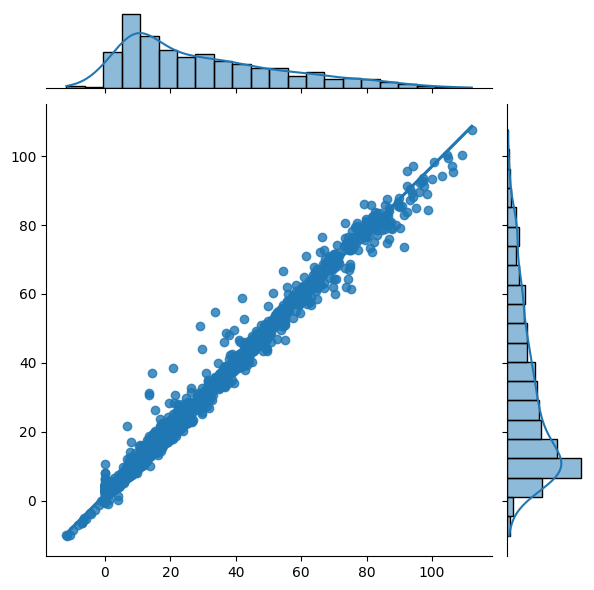

In [20]:
display(res)
sns.jointplot(kind='reg', x=all_true, y=all_pred)

*Model 2*

In [21]:
from handlers import fill_na_feats

In [22]:
'''Train first model using all data from EMTO'''
model1.fit(X1,y1)

'''
    Next step is to fill all empty features with zeros and than 
    to calculate predicted EMTO values from model 1 for VASP set
'''

df_vasp_feats = mlb_feats_from_elemental_hull(df_vasp)
df_vasp_feats = convert_to_feats(df_vasp_feats)

X2 = df_vasp_feats.drop(['ucf', 'base', 'dopants', 
                       'B','E',  'G', 'C_prime', 
                       'c11', 'c12', 'c44'], axis='columns').copy()

predicted_EMTO = model1.predict(fill_na_feats(model1_feats, X2))
X2_ = X2.copy()
X2_['predicted_EMTO'] = predicted_EMTO

y2 = df_vasp_feats[prop_to_pred]

model2_feats = list(X2_.columns)
print(f'Total {X2_.shape[1]} feats will be used')

100%|██████████| 70/70 [00:00<00:00, 6361.34it/s]

Total 241 feats will be used


*All available models that prectict PAW-SQS values:*
- ml_models.tpot_pipeline_C_prime_VASP_lib.py
- ml_models.tpot_pipeline_B_VASP_lib.py
- ml_models.tpot_pipeline_E_VASP_lib.py
- ml_models.tpot_pipeline_G_VASP_lib.py
- ml_models.tpot_pipeline_c11_VASP_lib.py
- ml_models.tpot_pipeline_c12_VASP_lib.py
- ml_models.tpot_pipeline_c44_VASP_lib.py

In [23]:
from ml_models.tpot_pipeline_C_prime_VASP_lib import *

model2 = model2()
model2

Pipeline(steps=[('stackingestimator-1',
                 StackingEstimator(estimator=KNeighborsRegressor(n_neighbors=37))),
                ('selectfwe',
                 SelectFwe(alpha=0.004,
                           score_func=<function f_regression at 0x7f81fc65d6c0>)),
                ('variancethreshold', VarianceThreshold(threshold=0.0001)),
                ('zerocount-1', ZeroCount()), ('zerocount-2', ZeroCount()),
                ('zerocount-3', ZeroCount()),
                ('pca', PCA(iterated_power=10, svd_solver='randomized')),
                ('stackingestimator-2',
                 StackingEstimator(estimator=RandomForestRegressor(max_features=0.3,
                                                                   min_samples_leaf=16,
                                                                   min_samples_split=7))),
                ('ridgecv', RidgeCV())])

interpolation abillity for second group of models tested via leave-one-out CV:

In [24]:
from handlers import leave_one_out_cv

In [25]:
true, pred, res = leave_one_out_cv(model2, X2_,y2)

100%|██████████| 70/70 [00:06<00:00, 11.32it/s]


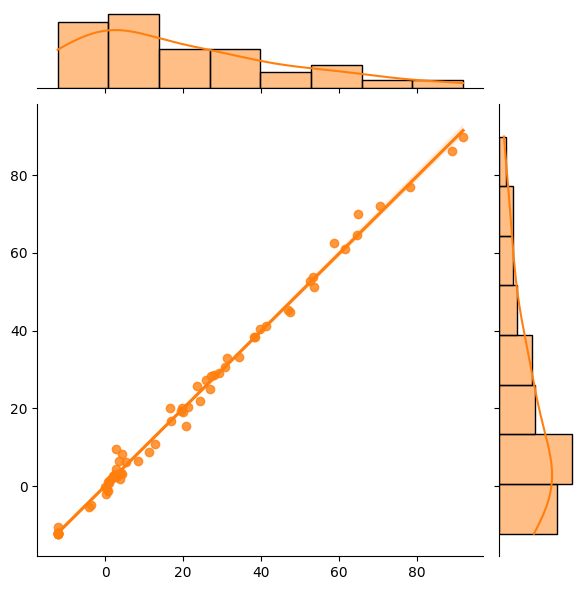

In [26]:
sns.jointplot(kind='reg', x=true, y=pred, color='tab:orange')

## Extrapolation ability testing

To estimate extrapolation rate we performed "system-fold" validation, which means, that in each step of such validation one entire system (e.g. Ti-Al) was excluded from a train set, and then we accurately check predicted values for excluded system. This validation is performed only for binaries.

In [27]:
# Validate only binaries
print('Prop_to_pred:', prop_to_pred)

Prop_to_pred: C_prime


Prepare datasets

In [28]:
from handlers import get_set_for_system_fold_cv
from handlers import system_fold_cv

In [29]:
tmp_df = get_set_for_system_fold_cv(df_emto, df_vasp, prop_to_pred)

tmp_df_emto = X1.copy()
tmp_df_emto[prop_to_pred] = df_emto[prop_to_pred]

tmp_df_vasp = X2.copy()
tmp_df_vasp[prop_to_pred] = df_vasp[prop_to_pred]

results,metrics = system_fold_cv(tmp_df,
                           model1, model2,
                           prop_to_pred,
                           tmp_df_emto, tmp_df_vasp)

Validated system: Ti-Ag
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 6162.83it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Al
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 6595.82it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Au
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7586.85it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Cd
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7526.25it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Co
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7429.06it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Cr
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 6521.06it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Cu
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 6159.33it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Fe
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7504.09it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Ga
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7462.75it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Ge
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7418.04it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Hf
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 21/21 [00:00<00:00, 6981.64it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Hg
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7082.27it/s]


-------------------------------------------------------------------------------
Validated system: Ti-In
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7404.10it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Ir
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 32/32 [00:00<00:00, 7430.94it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Mn
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 6318.87it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Mo
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 32/32 [00:00<00:00, 7475.23it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Nb
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 32/32 [00:00<00:00, 7559.43it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Ni
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 6364.34it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Os
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 32/32 [00:00<00:00, 7476.48it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Pd
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 6840.10it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Pt
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7205.51it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Re
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 32/32 [00:00<00:00, 7492.34it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Rh
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 32/32 [00:00<00:00, 7583.35it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Ru
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 32/32 [00:00<00:00, 7481.90it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Sc
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 21/21 [00:00<00:00, 6647.58it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Sn
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7276.89it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Ta
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 32/32 [00:00<00:00, 7523.84it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Tc
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 32/32 [00:00<00:00, 6977.79it/s]


-------------------------------------------------------------------------------
Validated system: Ti-V
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7294.03it/s]


-------------------------------------------------------------------------------
Validated system: Ti-W
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 32/32 [00:00<00:00, 7496.52it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Y
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 21/21 [00:00<00:00, 6654.10it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Zn
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7435.86it/s]


-------------------------------------------------------------------------------
Validated system: Ti-Zr
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7175.47it/s]


-------------------------------------------------------------------------------
1/2
Validated system: Zr-Ag
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7349.40it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Al
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7420.04it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Au
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7304.60it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Cd
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7303.33it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Co
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 6544.40it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Cr
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7093.36it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Cu
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7498.31it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Fe
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7325.44it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Ga
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7047.28it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Ge
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 6590.67it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Hf
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7431.00it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Hg
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 6793.50it/s]


-------------------------------------------------------------------------------
Validated system: Zr-In
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7237.38it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Ir
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 6471.72it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Mn
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 6848.22it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Mo
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7272.00it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Nb
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7455.47it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Ni
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7393.45it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Os
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7524.07it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Pd
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7468.05it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Pt
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 6433.64it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Re
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 6810.36it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Rh
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 6840.46it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Ru
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7426.94it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Sc
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7078.60it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Sn
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7311.82it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Ta
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 5911.50it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Tc
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 7453.76it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Ti
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7121.06it/s]


-------------------------------------------------------------------------------
Validated system: Zr-V
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 2869.73it/s]


-------------------------------------------------------------------------------
Validated system: Zr-W
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 31/31 [00:00<00:00, 6355.32it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Y
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 7294.02it/s]


-------------------------------------------------------------------------------
Validated system: Zr-Zn
Discrepancies in emto set: 0
Discrepancies in vasp set: 0


100%|██████████| 30/30 [00:00<00:00, 6412.98it/s]

-------------------------------------------------------------------------------
2/2


,r2_EMTO,MAE_EMTO,r2_VASP,MAE_VASP
0,0.884,4.365,0.944,3.85


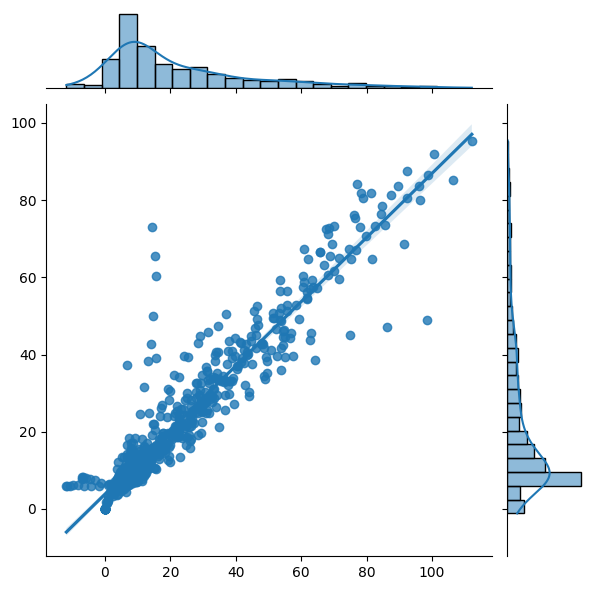

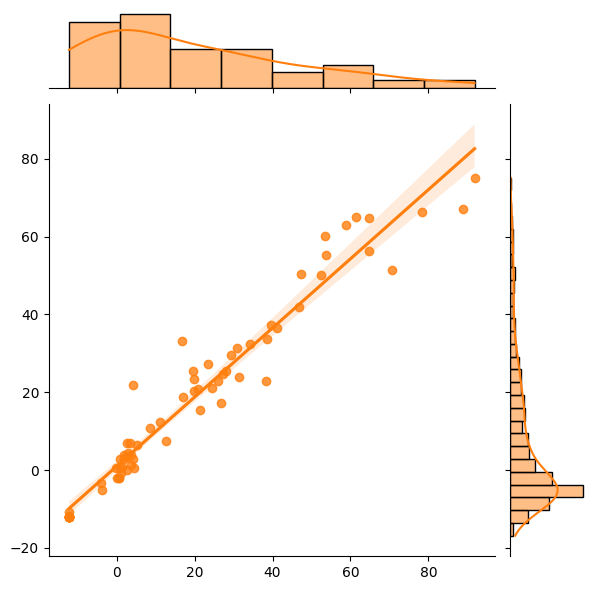

In [30]:
display(metrics)
sns.jointplot(x = results['True_EMTO'].values, y=results['Pred_EMTO'].values, 
              kind='reg')
sns.jointplot(x = results['True_VASP'].values, y=results['Pred_VASP'].values, 
              kind='reg', color='tab:orange')

---